In [17]:
import numpy as np
import pandas as pd
import cv2

In [18]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle,Rectangle,Polygon

In [19]:
from matplotlib.widgets import PolygonSelector

In [20]:
from opensfm import dataset,tracking
from opensfm import features as ft

In [21]:
from math import inf

In [22]:
from scipy.spatial import Delaunay,ConvexHull
from scipy.optimize import linprog

In [23]:
data = dataset.DataSet('./')
features=tracking.load_features(data,data.image_list)
matches=tracking.load_matches(data,data.image_list)

In [24]:
images=["images/"+image for image in data.image_list]
images=[cv2.imread(image) for image in images]

In [25]:
#Denormalisation
featuresCoorDen={}
for im in data.image_list:
    norCoord=features[0][im][:,0:2]
    height,width=data.image_size(im)
#     matrixToOriginal=np.array([[max(width,height),0,(width-1)/2],[0,max(width,height),(height-1)/2],[0,0,1]])
#     featuresCoorDen[im]=np.hstack((norCoord, np.ones((norCoord.shape[0], 1), dtype=norCoord.dtype)))@matrixToOriginal
    featuresCoorDen[im]=ft.denormalized_image_coordinates(features[0][im],width,height)

In [26]:
#bounding box of a circle
def getMinimumTemplate(image,row,col,nbKey,matches,disM):
    dis=0
    nb=0
    if nbKey==0:
        m=np.sum((matches-np.array([[row,col]]))**2,axis=1)<disM**2
        return disM,m
    while nb<nbKey:
        dis+=1
        m=np.sum((matches-np.array([[row,col]]))**2,axis=1)<dis**2
        nb=matches[m].shape[0]
    return dis,m

In [27]:
def returnWindow(image,d,r,c):
    hs,hf=c-d,c+d
    if hs<0:
        hs=0

    if hf>image.shape[0]-1:
        hf=image.shape[0]-1

    ws,wf=r-d,r+d
    if ws<0:
        ws=0

    if wf>image.shape[1]-1:
        wf=image.shape[1]-1

    g=image[hs:hf,ws:wf,:]
    
    r2,c2=r-ws,c-hs
    
    return g

In [28]:
def returnWindowRectangle(image,dR,dC,r,c):
    hs,hf=c-dC,c+dC
    if hs<0:
        hs=0

    if hf>image.shape[0]-1:
        hf=image.shape[0]-1

    ws,wf=r-dR,r+dR
    if ws<0:
        ws=0

    if wf>image.shape[1]-1:
        wf=image.shape[1]-1

    g=image[hs:hf,ws:wf,:]
    
    r2,c2=r-ws,c-hs
    return g

In [29]:
# check wether a point is inside the convex hull
# convex combination of points
def in_hull(keyPoints,row,col):
    dim=keyPoints.shape[0]
    A=keyPoints.T
    A=np.vstack((A,np.ones((1,dim))))
    x=np.zeros(dim)
    b=np.array([[row],[col],[1]])
    lp=linprog(x,A_eq=A,b_eq=b,bounds = (0, None))
    return lp.success
# in_hull(kp1,200,40)

In [59]:
#need to deal with linear positionnement check det?
def getClosestKeyPoints(row,col,keyPoints,nbKey):
    a=np.sum((keyPoints-np.array([[row,col]]))**2,axis=1)
    return np.argsort(a)[0:nbKey]

#add max distance
def getClosestSurrondingPoints(row,col,keyPoints,nbKey):
    dis=1
    nb=0
    mask=np.sum((keyPoints-np.array([[row,col]]))**2,axis=1)<1
    while nb<nbKey :
        dis+=1
        mask=np.sum((keyPoints-np.array([[row,col]]))**2,axis=1)<dis**2
        nb=keyPoints[mask].shape[0]
    return mask

def findindingClosest3Points(row,col,keyPoints,triang):
    g=triang.simplices[triang.find_simplex(np.array([row,col]))]
    if np.any(g==(-1)):
        return -1
#     print(g.shape,tri.neighbors[g])
#     print(np.append(tri.neighbors[g],np.array([g]),axis=0).shape)
    print(tri.neighbors[g].ravel().shape)
    neighAll=np.append(tri.neighbors[g].ravel(),g)
    neighAll=np.unique(neighAll)
#     neighAll=np.argsort(np.sum((keyPoints[neighAll]-np.array([[row,col]]))**2,axis=1))[0:6]
    print(g,neighAll,keyPoints[neighAll])
    return neighAll
#     return g
    
def findindingClosest3Points(surface,keyPoints,triang,onlyThree=True):
    g=triang.simplices[triang.find_simplex(surface)]
    if np.any(g==(-1)):
        return -1
    print(triang.simplices[triang.neighbors[triang.find_simplex(surface)]].shape,g.shape)
    neighAll=np.append(triang.simplices[triang.neighbors[triang.find_simplex(surface)]],g.reshape(g.shape[0],g.shape[1],1),axis=2)
    neighAll=neighAll.reshape(neighAll.shape[0],neighAll.shape[1]*neighAll.shape[2])
    
    neighAll=np.apply_along_axis(np.unique,1,neighAll)
#     print(tri.neighbors[g])
#     print(neighAll)
#     neighAll=np.unique(neighAll,axis=0)
# # #     neighAll=np.argsort(np.sum((keyPoints[neighAll]-np.array([[row,col]]))**2,axis=1))[0:6]
#     print(g,neighAll.shape)
    if onlyThree:
        return g
    return neighAll
#     return g   
# findindingClosest3Points(sur,kp1,tri)

In [32]:
#returns rectangle bounding box
#there isnt any need to check if its within the picture because it only takes into account min and max of points
#     only need topl and botR
#     topL,topR,botL,botR=(minR,minC),(maxR,minC),(minR,maxC),(maxR,maxC)
#     return topL,topR,botL,botR
def getBoundingBox(pts,i):
    [minR,minC]=np.min(pts[i],axis=0)
    [maxR,maxC]=np.max(pts[i],axis=0)  
    topL,botR=(int(minR),int(minC)),(int(maxR)+1,int(maxC)+1)
    return topL,botR

In [33]:
def fromBbToImage(image,topL,botR):
    return image[topL[1]:botR[1],topL[0]:botR[0],:]

In [34]:
#oriented graph


In [35]:
#data
kp1=featuresCoorDen[data.image_list[0]][matches[(data.image_list[1],data.image_list[0])][:,1]]
kp2=featuresCoorDen[data.image_list[1]][matches[(data.image_list[1],data.image_list[0])][:,0]]


# kp1=np.unique(kp1,axis=0)
# kp2=np.unique(kp2,axis=0)

image1,image2=images[0],images[1]

kp1=np.append(kp1,np.array([[0,0],[0,image1.shape[0]-1],[image1.shape[1]-1,0],[image1.shape[1]-1,image1.shape[0]-1]]),axis=0)
kp2=np.append(kp2,np.array([[0,0],[0,image2.shape[0]-1],[image2.shape[1]-1,0],[image2.shape[1]-1,image2.shape[0]-1]]),axis=0)


tri = Delaunay(kp1)

<IPython.core.display.Javascript object>


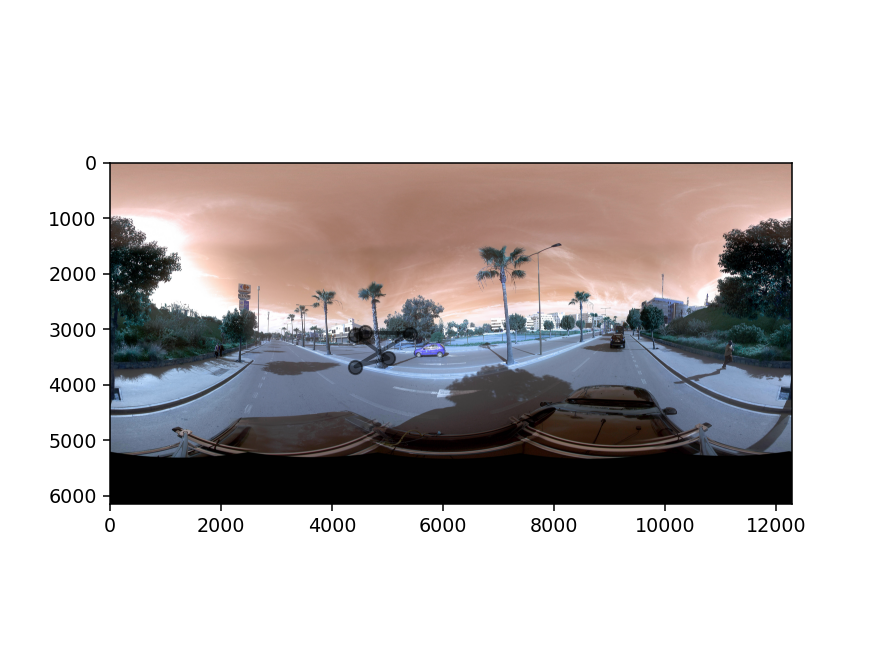

In [42]:
%matplotlib notebook
fig,ax=plt.subplots(1)
ax.imshow(image1)
fig.show()
selector = PolygonSelector(ax, lambda *args: None)

# from DOCUMENTATION
# print("Click on the figure to create a polygon.")
# print("Press the 'esc' key to start a new polygon.")
# print("Try holding the 'shift' key to move all of the vertices.")
# print("Try holding the 'ctrl' key to move a single vertex.")

In [43]:
#oriented list of vertices
sur=np.array(selector.verts)

In [60]:
tri = Delaunay(kp1)  
sur=sur.astype(int)
mask=findindingClosest3Points(sur,kp1,tri)

if mask.any()==-1:
    raise Exception("triangulation didnt find any simplex/try with another method")

scale=1    

# print(mask)
# print(mask.ravel())
kpP1=kp1[mask]
kpP2=kp2[mask]
print(mask)
print(kpP1)

#additionnal step
# l=np.argsort(np.sum((kpP1-sur)**2,axis=2))[0:min(6,kpP1.shape[0])]
# kpP1=kpP1[l]
# kpP2=kpP2[l]

# print("r",kpP1)

# # coordinates of the bounding boxes
# tL1,br1
cords1=np.array([getBoundingBox(kpP1,i) for i in range(kpP1.shape[0])])
cords2=np.array([getBoundingBox(kpP2,i) for i in range(kpP2.shape[0])])


# print(cords1)
print(sur.shape)

# #boxes -> images
box1,box2=np.array([fromBbToImage(image1,cords1[i,0],cords1[i,1]) for i in range(kpP1.shape[0])],dtype=object),np.array([fromBbToImage(image2,cords2[i,0],cords2[i,1]) for i in range(kpP2.shape[0])],dtype=object)

# #choosing a window centered in the point that have dimensions smaller than the bounding box
# kernelD=40
# #new coordinates in the first box
newCoorB1=sur-cords1[:,0,:]
# print(newCoorB1)
# # while r2-kernelD<0 or c2-kernelD<0 or r2+kernelD>=br1[0]-tL1[0] or c2+kernelD>=br1[1]-tL1[1] :
# #     kernelD-=1

# # temp=returnWindow(image1,kernelD,row,col)

# # print(kernelD)

kernelDR=[25]*kpP1.shape[0]
kernelDC=[25]*kpP1.shape[0]

for i in range(kpP1.shape[0]):
    while newCoorB1[i,0]-kernelDR[i]<0 or  newCoorB1[i,0]+kernelDR[i]>=cords1[i,1,0]-cords1[i,0,0] :
        kernelDR[i]-=1

    while  newCoorB1[i,1]-kernelDC[i]<0 or  newCoorB1[i,1]+kernelDC[i]>=cords1[i,1,1]-cords1[i,0,1] :
        kernelDC[i]-=1

print(kernelDR,kernelDC)
temp=np.array([returnWindowRectangle(image1,kernelDR[i],kernelDC[i],sur[i,0],sur[i,1]) for i in range (kpP1.shape[0])])

print(temp.shape)
# #coorelation template based matching test:
res=np.array([cv2.matchTemplate(box2[i],temp[i],cv2.TM_CCOEFF_NORMED) for i in range(kpP1.shape[0])],dtype=object)
print(res.shape)
max_loc =np.array([ cv2.minMaxLoc(res[i])[3] for i in range(kpP1.shape[0])])
    
# # closestKeyMask=getClosestKeyPoints(row,col,kp1,1)
# # closestK1=kp1[closestKeyMask]
# # closestK2=kp2[closestKeyMask]
# # ciSearch=(closestK2-tL2-np.array([temp.shape[1]-1,temp.shape[0]-1])).astype(int)

# # print(ciSearch)
# # radius=100
# # fl=res[ciSearch[0,0]-radius:ciSearch[0,0]+radius,ciSearch[0,1]-radius:ciSearch[0,1]+radius]
# # max_loc2=cv2.minMaxLoc(fl)[3]
# # max_loc2=max_loc2[0]+ciSearch[0,0]-radius,+max_loc2[1]+ciSearch[0,1]-radius

# # max_loc=max_loc2

centroidFoundB2=[(max_loc[i][0]+(temp[i].shape[1]*scale)/2,max_loc[i][1]+(temp[i].shape[0]*scale)/2) for i in range(kpP2.shape[0])]
centroidFound=[(centroidFoundB2[i][0]+cords2[i,0,0] ,centroidFoundB2[i][1]+cords2[i,0,1])  for i in range(kpP2.shape[0])]

print(centroidFound)

(5, 3, 3) (5, 3)
[[139 185  86]
 [135 160 165]
 [245 299 136]
 [167 257 135]
 [187 181 214]]
[[[5151.24121094 2985.21362305]
  [4610.46289062 3178.45214844]
  [4485.37890625 2998.41357422]]

 [[5226.97216797 3345.97900391]
  [5247.18505859 2993.64013672]
  [5953.69433594 2858.59765625]]

 [[4125.68554688 3468.09692383]
  [4796.52148438 3706.46728516]
  [3672.76660156 3745.90478516]]

 [[4860.39453125 3684.83007812]
  [4831.60742188 3530.78076172]
  [5226.97216797 3345.97900391]]

 [[4386.85986328 3142.36401367]
  [4416.30957031 3001.54418945]
  [4489.97509766 3134.51025391]]]
(5, 2)
[25, 25, 25, 25, 25] [25, 25, 25, 25, 25]
(5, 50, 50, 3)
(5,)
[(4488.0, 3052.0), (5631.0, 3066.0), (3671.0, 3446.0), (4372.0, 3438.0), (4261.0, 3102.0)]


<IPython.core.display.Javascript object>


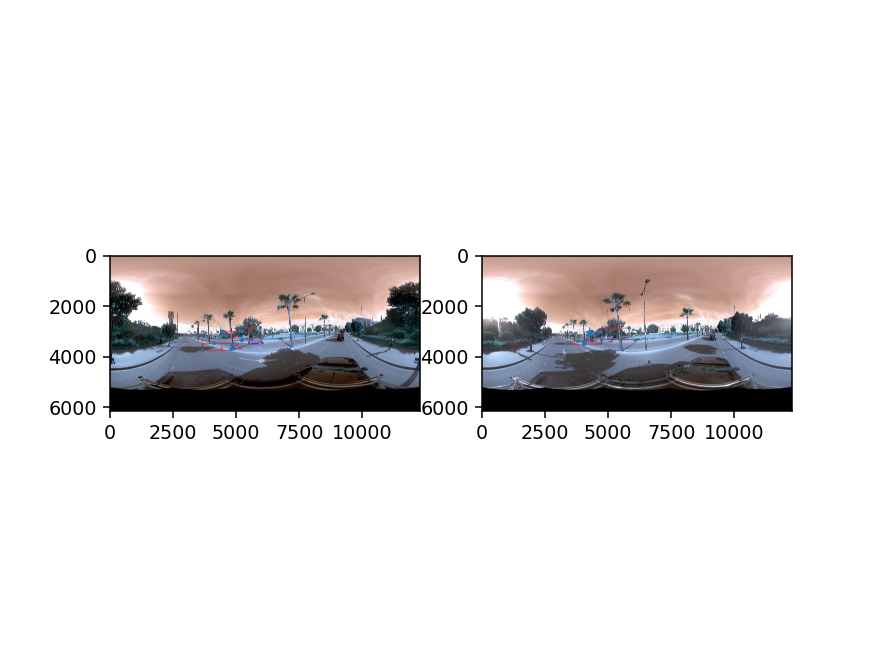

In [61]:
# showing of the bounding boxes in the context of the photo
cop1=image1.copy()
cop2=image2.copy()

for i in range(kpP1.shape[0]):
#     print(cords1[i,0],cords1[i,1])
    cv2.rectangle(cop1,tuple(cords1[i,0]),tuple(cords1[i,1]),(255,0,0),20)
    cv2.rectangle(cop2,tuple(cords2[i,0]),tuple(cords2[i,1]),(255,0,0),20)

%matplotlib notebook
fig,ax=plt.subplots(1,2)
ax[0].imshow(cop1)
for i in range(kpP1.shape[0]):
    for key in kpP1[i]:
        ax[0].add_patch(Circle(key,70))
    ax[0].add_patch(Circle(sur[i],10,color='red'))
ax[1].imshow(cop2)
for i in range(kpP2.shape[0]):
    for key in kpP2[i]:
        ax[1].add_patch(Circle(key,70))

<IPython.core.display.Javascript object>


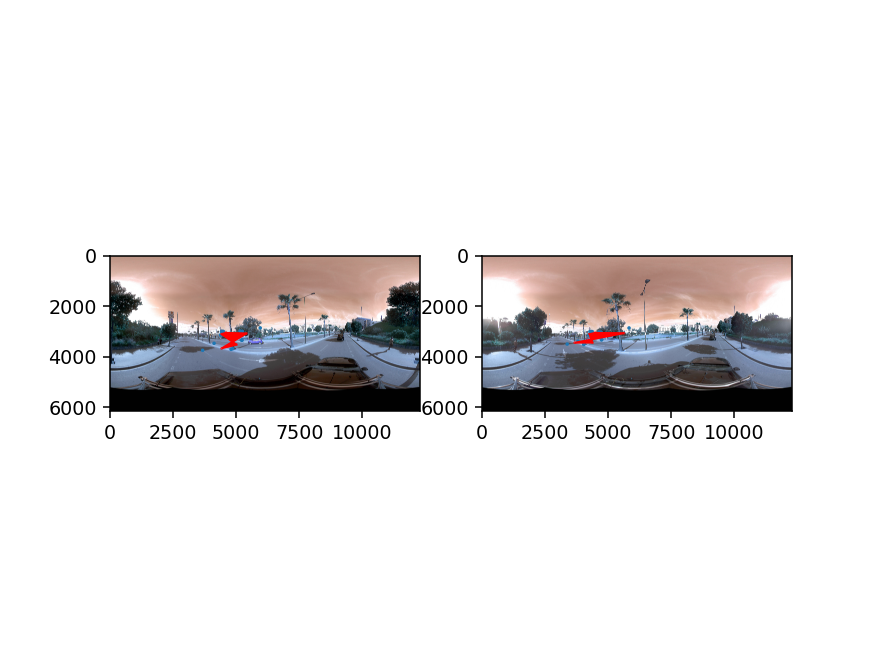

In [62]:
# showing the results:
cop1=image1.copy()
cop2=image2.copy()

%matplotlib notebook
fig,ax=plt.subplots(1,2)
ax[0].imshow(cop1)
for i in range(kpP1.shape[0]):
    for key in kpP1[i]:
        ax[0].add_patch(Circle(key,70))
    ax[0].add_patch(Circle(sur[i],10,color='red'))
ax[0].add_patch(Polygon(sur,10,color='red'))
ax[1].imshow(cop2)
for i in range(kpP2.shape[0]):
    for key in kpP2[i]:
        ax[1].add_patch(Circle(key,70))
    ax[1].add_patch(Circle(centroidFound[i],10,color='red'))
ax[1].add_patch(Polygon(centroidFound,10,color='red'))

<IPython.core.display.Javascript object>


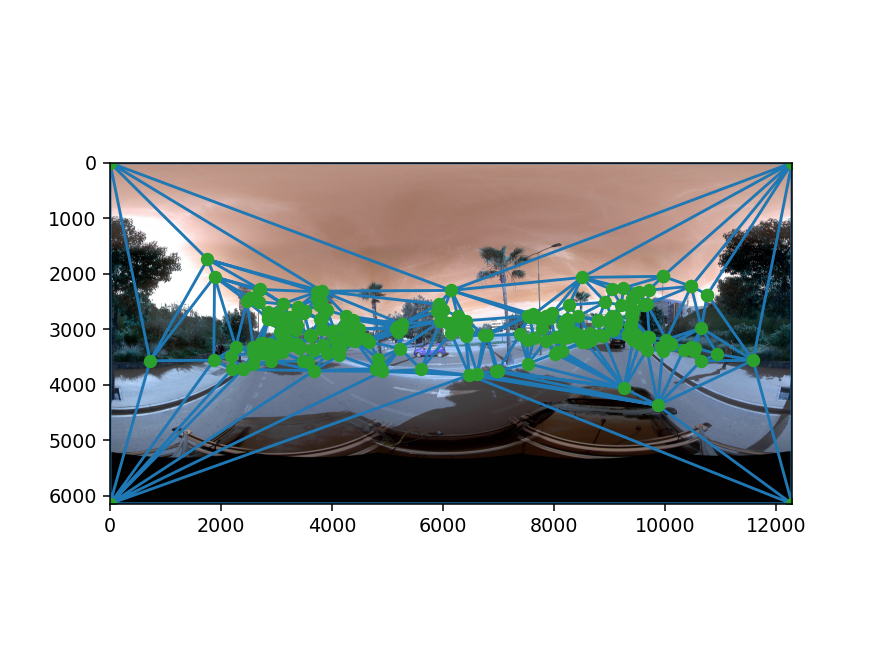

In [47]:
%matplotlib notebook
fig,ax=plt.subplots(1)
ax.triplot(kp1[:,0],kp1[:,1],tri.simplices)
ax.imshow(image1)
ax.plot(kp1[:,0],kp1[:,1], 'o')

In [48]:
kp1[[8,19,30,102,217,255]]

array([[1755.79492188, 1739.33410645],
       [1883.72460938, 2052.64013672],
       [ 721.62207031, 3567.04589844],
       [2704.18237305, 2280.19628906],
       [2682.07128906, 2299.62597656],
       [3732.44238281, 2324.58691406]])